In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow import keras
import matplotlib.cm as cm
from IPython.display import Image, display


           Count
Lung 5.0      90
lung reco     58


<AxesSubplot: >

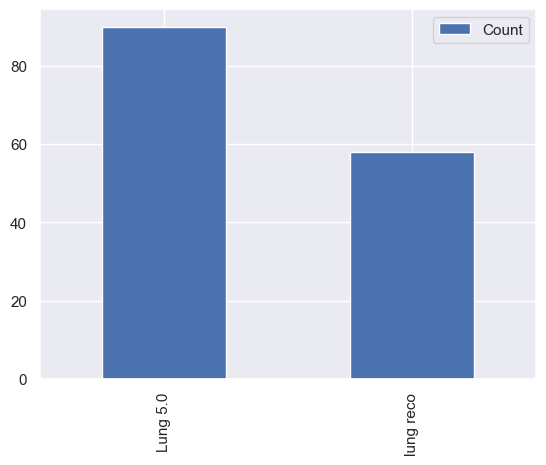

In [2]:
data_path = "basedata/"
    

sns.set_theme()
count = pd.DataFrame({"Count": [len(os.listdir(data_path + "yes")), len(os.listdir(data_path + "no"))]}, index=["Lung 5.0", "lung reco"])
print(count.head())

count.plot(kind="bar")

Unbalanced dataset. We will balance it by upscaling with:

In [3]:
pip install imagesize


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: C:\Users\User\pyver\py3107\python.exe -m pip install --upgrade pip


<AxesSubplot: xlabel='Height', ylabel='Count'>

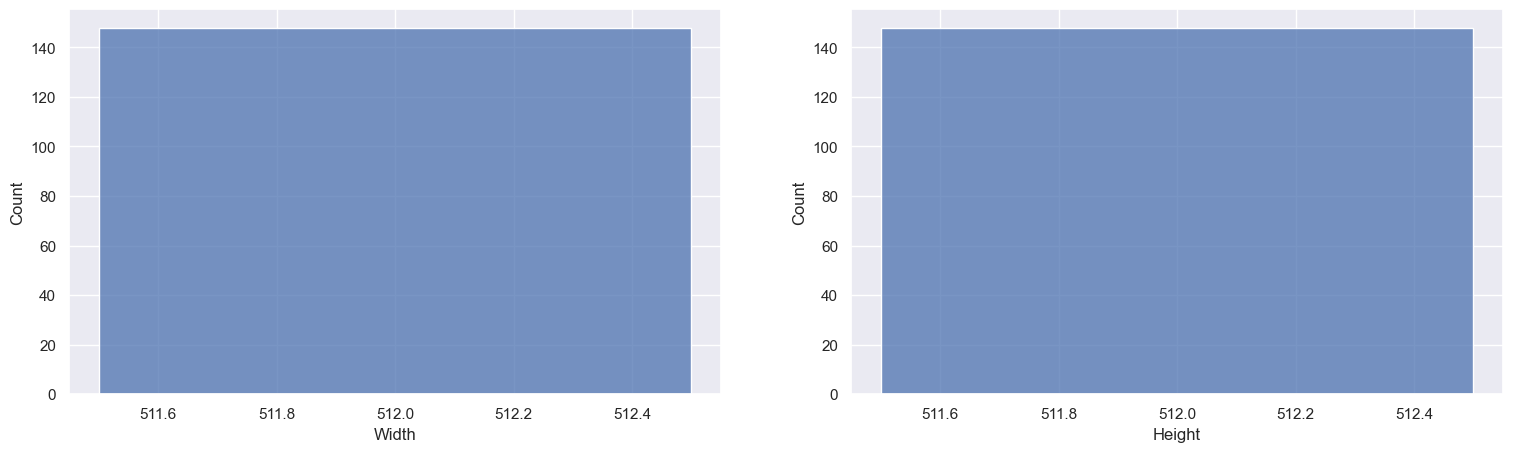

In [4]:
import imagesize

ws = []
hs = []
for data in ["yes", "no"]:
    for image in os.listdir(data_path + data):
        w, h = imagesize.get(data_path + data + "/" + image)
        ws.append(w)
        hs.append(h)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(18.5, 5)
sns.histplot(pd.DataFrame({"Width": ws}), x="Width", ax=axs[0])
sns.histplot(pd.DataFrame({"Height": hs}), x="Height", ax=axs[1])

Text(0.5, 1.0, 'No tumor')

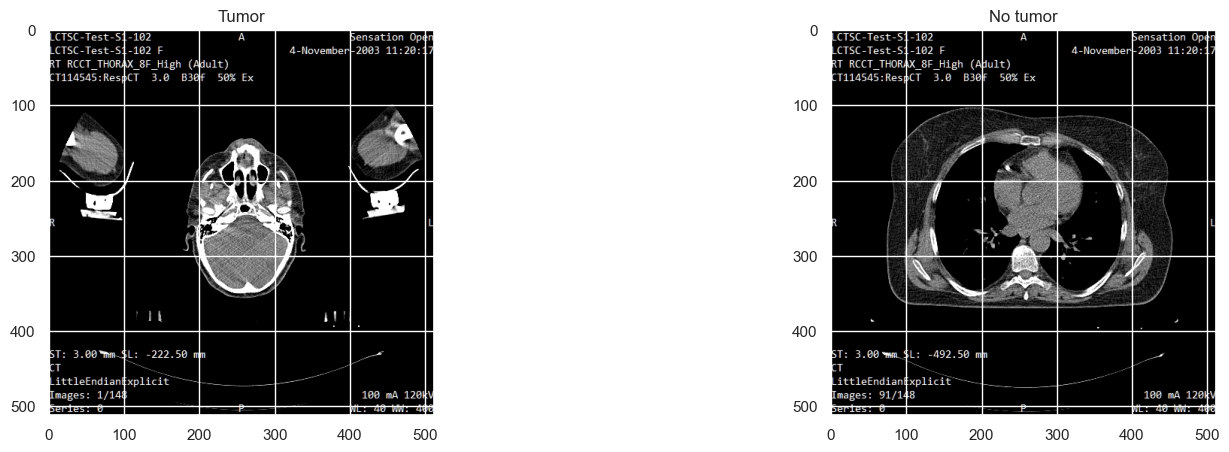

In [5]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(18.5, 5)

axs[0].imshow(cv2.imread("basedata/yes/img-00001-00001.jpg"))
axs[0].set_title("Tumor")

axs[1].imshow(cv2.imread("basedata/no/img-00001-00091.jpg"))
axs[1].set_title("No tumor")

In [6]:
IMG_SIZE = 256
BATCH_SIZE = 32

In [7]:
import tensorflow as tf

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="categorical",
    class_names=["no", "yes"],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=1,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="categorical",
    class_names=["no", "yes"],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=1,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False
)

Found 148 files belonging to 2 classes.
Using 119 files for training.
Found 148 files belonging to 2 classes.
Using 29 files for validation.


In [8]:

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import layers


data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),
])

def build_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    model = MobileNetV2(include_top=False, weights="imagenet", input_tensor=x)
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="sigmoid", name="pred")(x)
    model = tf.keras.Model(inputs, outputs, name="EfficientNetB0")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["binary_accuracy"])
    return model

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_path = "./brain_tumor_detection_mobileNetV2.hdf5"

model = build_model()
EPOCHS = 100
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)



1/1 [==============================] - 1s 1s/step - loss: 0.6687 - binary_accuracy: 0.5517
(2, 2)
1/1 [==============================] - 1s 883ms/step


<AxesSubplot: >

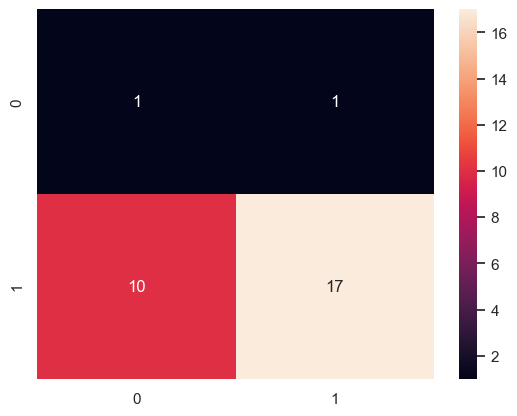

In [10]:
model.evaluate(val_dataset)

confusion_m = np.array([[0, 0], [0, 0]])
print(confusion_m.shape)
for images, labels in val_dataset:
    confusion_m += confusion_matrix(np.array(model.predict(images)).argmax(axis=-1), np.array(labels).argmax(axis=1))

sns.heatmap(confusion_m, annot=True)

In [11]:
# print(model.summary())

In [12]:
def create_heatmap(image, model, last_layer_name, pred_index=None):
    img_array = keras.preprocessing.image.img_to_array(image)
    img_array = np.expand_dims(img_array, axis=0)
    grad_model = tf.keras.models.Model([model.inputs], 
                                     [model.get_layer(last_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    last_layer_output = last_layer_output[0]
    heatmap = tf.matmul(last_layer_output, pooled_grads[..., tf.newaxis])
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

(256, 256, 3)


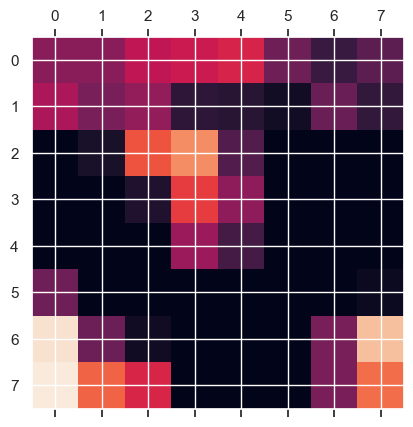

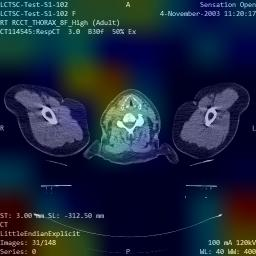

(256, 256, 3)


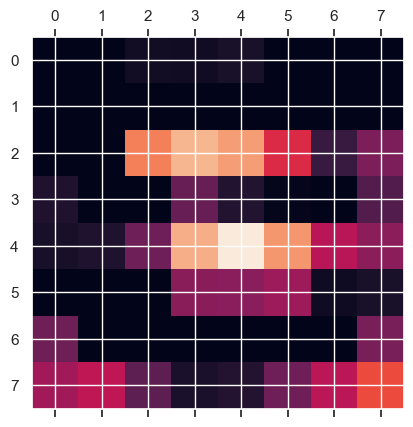

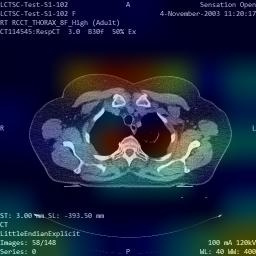

(256, 256, 3)


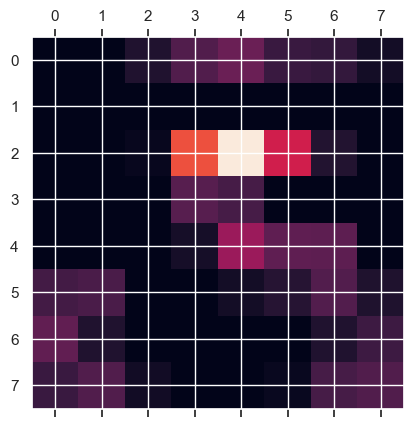

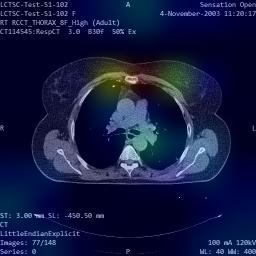

(256, 256, 3)


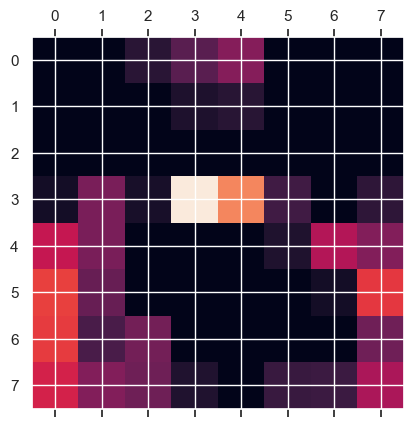

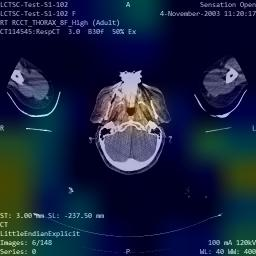

(256, 256, 3)


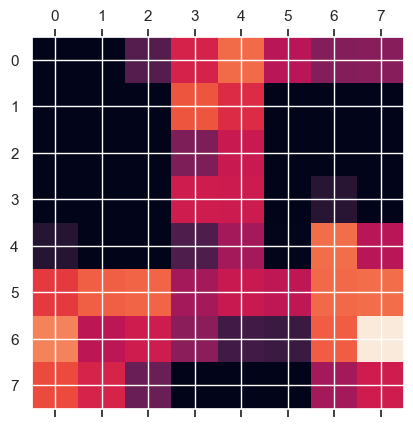

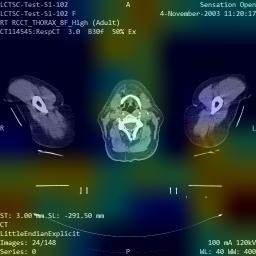

(256, 256, 3)


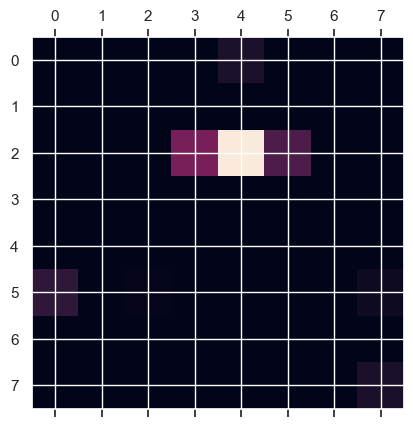

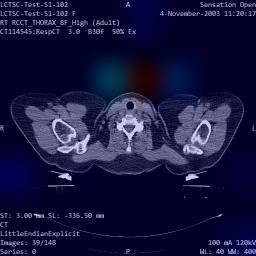

(256, 256, 3)


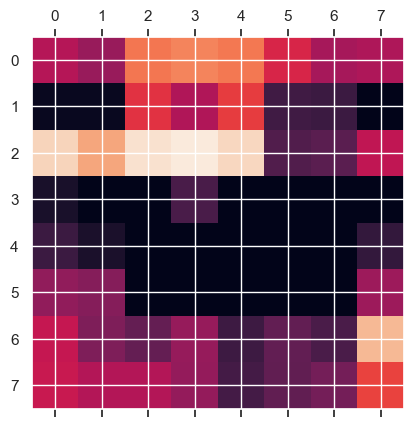

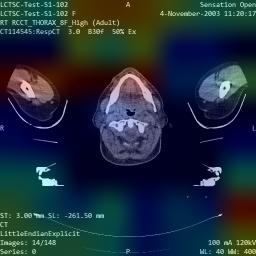

In [13]:
for images, labels in val_dataset:
    for i in range(10):
        if np.array(labels)[i].argmax() == 1: 
            img_array = np.array(images)[i]
            print(img_array.shape)
            heatmap = create_heatmap(img_array, model, "Conv_1")
            plt.show()
            plt.matshow(heatmap)
            plt.show()
            cam_path = "cam.jpg"
            alpha = 0.4
            heatmap = np.uint8(255 * heatmap)

            jet = cm.get_cmap("jet")

            jet_colors = jet(np.arange(256))[:, :3]
            jet_heatmap = jet_colors[heatmap]

            jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
            jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
            jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

            superimposed_img = jet_heatmap * alpha + img_array
            superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)


            superimposed_img.save(cam_path)
            display(Image(cam_path))
    break